In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))

['ratings.csv', 'links.csv', 'tags.csv', 'README.txt', 'movies.csv']


In [2]:
ratings = pd.read_csv('../input/ratings.csv')
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [3]:
ratings.shape

(100004, 4)

In [4]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()
n_user = len(users)
n_movie =  len(movies)
print(n_user , n_movie)

671 9066


In [5]:
ratings["userId"].value_counts().sort_values(ascending=False)[0:15]

547    2391
564    1868
624    1735
15     1700
73     1610
452    1340
468    1291
380    1063
311    1019
30     1011
294     947
509     923
580     922
213     910
212     876
Name: userId, dtype: int64

In [6]:
ratings["movieId"].value_counts().sort_values(ascending=False)[0:15]

356     341
296     324
318     311
593     304
260     291
480     274
2571    259
1       247
527     244
589     237
1196    234
110     228
1270    226
608     224
2858    220
Name: movieId, dtype: int64

In [7]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}
ratings['userId'] = ratings['userId'].apply(lambda x: userid2idx[x])
ratings['movieId'] = ratings['movieId'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(ratings)) < 0.8
train = ratings[split]
valid = ratings[~split]
print(train.shape , valid.shape)

(79868, 4) (20136, 4)


In [8]:
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.regularizers import l2 , l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
filepath="recommend_weights.hdf5"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

## The embedding layer size of 30 is tried and compared to that of 64. In the previous notebook I discussed about embedding layer of 50. This is another hyper parameter to deal with in collaborative filtering. 

In [10]:
factor =30
user_input = Input(shape=(1,), dtype='int64', name='user_input')
user_emb = Embedding(n_user, factor, input_length=1, W_regularizer=l2(1e-4))(user_input)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 30, input_length=1, embeddings_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


### Making the input layer and feeding the input to the embedding layer so as to turn the input vector to the dense latent vector and feature extraction process.

In [11]:
movie_input = Input(shape=(1,), dtype='int64', name='movie_input')
movie_emb = Embedding(n_movie, factor, input_length=1, W_regularizer=l2(1e-4))(movie_input)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 30, input_length=1, embeddings_regularizer=<keras.reg...)`
  


In [12]:
user_bias =  Embedding(n_user, 1, input_length = 1)(user_input)
user_bias = Flatten()(user_bias)
movie_bias = Embedding(n_movie, 1, input_length =1)(movie_input)
movie_bias = Flatten()(movie_bias)

### Adding the necessary biases and merging the 2 sources of inputs (movies embedding matrix and users embedding matrix). Finally completing the neural network ......

In [15]:
lr =0.0001
# Building a linear model
inp = merge([user_emb, movie_emb], mode = 'dot')
inp = Flatten()(inp)
inp = keras.layers.add(([inp, user_bias]))
inp = Dense(16 , activation = 'relu')(inp)
inp = Dropout(0.4)(inp)
inp = Dense(1)(inp)
inp = keras.layers.add(([inp, movie_bias]))
model = Model([user_input, movie_input], inp)
model.compile(Adam(lr), loss = 'mse')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 30)        20130       user_input[0][0]                 
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 30)        271980      movie_input[0][0]                
__________________________________________________________________________________________________
merge_2 (M

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [16]:
history = model.fit([train.userId, train.movieId], train.rating, batch_size=64, epochs=15, 
          validation_data=([valid.userId, valid.movieId], 
            valid.rating) , callbacks=[checkpoint])

Train on 79868 samples, validate on 20136 samples
Epoch 1/15
79868/79868 [==============================] - 8s 105us/step - loss: 10.7473 - val_loss: 7.8937

Epoch 00001: val_loss did not improve
Epoch 2/15
79868/79868 [==============================] - 8s 100us/step - loss: 5.2594 - val_loss: 2.8329

Epoch 00002: val_loss did not improve
Epoch 3/15
79868/79868 [==============================] - 8s 100us/step - loss: 2.1936 - val_loss: 1.2171

Epoch 00003: val_loss did not improve
Epoch 4/15
79868/79868 [==============================] - 8s 99us/step - loss: 1.7102 - val_loss: 1.0537

Epoch 00004: val_loss improved from 1.07104 to 1.05373, saving model to recommend_weights.hdf5
Epoch 5/15
79868/79868 [==============================] - 8s 100us/step - loss: 1.6236 - val_loss: 0.9986

Epoch 00005: val_loss improved from 1.05373 to 0.99863, saving model to recommend_weights.hdf5
Epoch 6/15
79868/79868 [==============================] - 8s 101us/step - loss: 1.5451 - val_loss: 0.9619

Epoc

### Till now the mean square error is 0.8379.

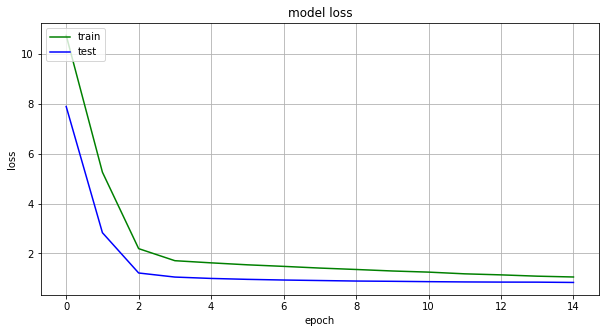

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

### Continuing ....

In [18]:
history = model.fit([train.userId, train.movieId], train.rating, batch_size=128, epochs=10, 
          validation_data=([valid.userId, valid.movieId], 
            valid.rating))

Train on 79868 samples, validate on 20136 samples
Epoch 1/10
79868/79868 [==============================] - 4s 50us/step - loss: 1.0191 - val_loss: 0.8380
Epoch 2/10
79868/79868 [==============================] - 4s 50us/step - loss: 0.9947 - val_loss: 0.8369
Epoch 3/10
79868/79868 [==============================] - 4s 51us/step - loss: 0.9641 - val_loss: 0.8336
Epoch 4/10
79868/79868 [==============================] - 4s 50us/step - loss: 0.9393 - val_loss: 0.8344
Epoch 5/10
79868/79868 [==============================] - 4s 51us/step - loss: 0.9115 - val_loss: 0.8315
Epoch 6/10
79868/79868 [==============================] - 4s 51us/step - loss: 0.8898 - val_loss: 0.8272
Epoch 7/10
79868/79868 [==============================] - 4s 50us/step - loss: 0.8640 - val_loss: 0.8280
Epoch 8/10
79868/79868 [==============================] - 4s 50us/step - loss: 0.8424 - val_loss: 0.8254
Epoch 9/10
79868/79868 [==============================] - 4s 49us/step - loss: 0.8183 - val_loss: 0.8285
Epoch

### Now the mean square turned from 0.8379 to 0.8254 which is improved ....

### Embedding matrix size changed to 64

In [26]:
factor =64
user_input = Input(shape=(1,), dtype='int64', name='user_input')
user_emb = Embedding(n_user, factor, input_length=1, W_regularizer=l2(1e-4))(user_input)
movie_input = Input(shape=(1,), dtype='int64', name='movie_input')
movie_emb = Embedding(n_movie, factor, input_length=1, W_regularizer=l2(1e-4))(movie_input)
user_bias =  Embedding(n_user, 1, input_length = 1)(user_input)
user_bias = Flatten()(user_bias)
movie_bias = Embedding(n_movie, 1, input_length =1)(movie_input)
movie_bias = Flatten()(movie_bias)
lr =0.0001
# Building a linear model
inp = merge([user_emb, movie_emb], mode = 'dot')
inp = Flatten()(inp)
inp = keras.layers.add(([inp, user_bias]))
inp = Dense(16 , activation = 'relu')(inp)
inp = Dropout(0.4)(inp)
inp = Dense(1)(inp)
inp = keras.layers.add(([inp, movie_bias]))
model = Model([user_input, movie_input], inp)
model.compile(Adam(lr), loss = 'mse')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 64)        42944       user_input[0][0]                 
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 64)        580224      movie_input[0][0]                
__________________________________________________________________________________________________
merge_4 (M

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 64, input_length=1, embeddings_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 64, input_length=1, embeddings_regularizer=<keras.reg...)`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [27]:
history = model.fit([train.userId, train.movieId], train.rating, batch_size=64, epochs=15, 
          validation_data=([valid.userId, valid.movieId], 
            valid.rating) , callbacks=[checkpoint])

Train on 79868 samples, validate on 20136 samples
Epoch 1/15
79868/79868 [==============================] - 9s 116us/step - loss: 11.7039 - val_loss: 9.3696

Epoch 00001: val_loss did not improve
Epoch 2/15
79868/79868 [==============================] - 9s 112us/step - loss: 6.8963 - val_loss: 4.4992

Epoch 00002: val_loss did not improve
Epoch 3/15
79868/79868 [==============================] - 9s 114us/step - loss: 3.2547 - val_loss: 1.8227

Epoch 00003: val_loss did not improve
Epoch 4/15
79868/79868 [==============================] - 9s 117us/step - loss: 2.0577 - val_loss: 1.1970

Epoch 00004: val_loss did not improve
Epoch 5/15
79868/79868 [==============================] - 9s 116us/step - loss: 1.8220 - val_loss: 1.0691

Epoch 00005: val_loss did not improve
Epoch 6/15
79868/79868 [==============================] - 9s 115us/step - loss: 1.7379 - val_loss: 1.0159

Epoch 00006: val_loss did not improve
Epoch 7/15
79868/79868 [==============================] - 9s 116us/step - loss:

### Till now the mean square is 0.8614 but still their is scope for more improvement ....

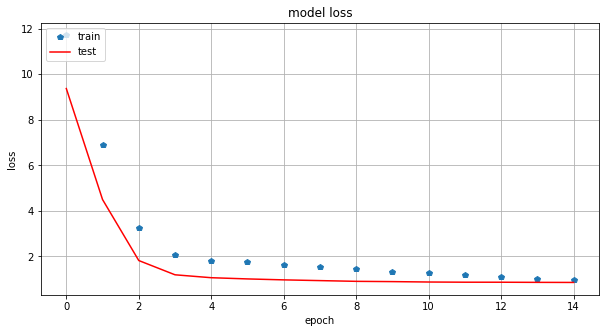

In [35]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'p')
plt.plot(history.history['val_loss'] , 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

### Further reducing the learning rate and thus improving more and achieving mean square error of 0.8565

### Similarly playing with batch_size and other hyperparameters after analysing the situation might lead to even better performance than this ....

In [36]:
model.optimizer.lr = 0.00001
history = model.fit([train.userId, train.movieId], train.rating, batch_size=128, epochs=2, 
          validation_data=([valid.userId, valid.movieId], 
            valid.rating))

Train on 79868 samples, validate on 20136 samples
Epoch 1/2
79868/79868 [==============================] - 4s 55us/step - loss: 0.9059 - val_loss: 0.8600
Epoch 2/2
79868/79868 [==============================] - 4s 55us/step - loss: 0.8673 - val_loss: 0.8565


### Further reduction didn't helped but overfitted the model.

In [37]:
model.optimizer.lr = 0.000001
history = model.fit([train.userId, train.movieId], train.rating, batch_size=128, epochs=2, 
          validation_data=([valid.userId, valid.movieId], 
            valid.rating))

Train on 79868 samples, validate on 20136 samples
Epoch 1/2
79868/79868 [==============================] - 4s 55us/step - loss: 0.8295 - val_loss: 0.8622
Epoch 2/2
79868/79868 [==============================] - 5s 57us/step - loss: 0.7860 - val_loss: 0.8649
